<a href="https://colab.research.google.com/github/shravankumargulvadi/Assignment-12/blob/master/Assignment_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Assignment-12
First Attempt at achieving super convergence,

Implemented One cycle LR,

Network Architechture, Augmentation and hyperparameters as per DAVID NET(DAWN bench)

## Result
Max Val_accu with in 24 epochs=84.8%
Time taken close to 20mins











In [1]:
import time
import keras
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np 
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D, ZeroPadding2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, Lambda, Add
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback



Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [3]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


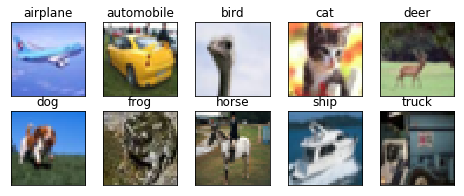

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [6]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:


X_train_mean = np.mean(train_features, axis=(0,1,2))
X_train_std = np.std(train_features, axis=(0,1,2))
X_train = (train_features - X_train_mean) / X_train_std
X_test = (test_features - X_train_mean) / X_train_std

## Data Augmentation: Cutout

In [0]:
def cutout(img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        n_holes=1
        length=8
        img= np.array(img)
        h = img.shape[0]
        w = img.shape[1]
        

        mask = np.ones((h, w, 3), np.float32)

        for n in range(n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = int(np.clip(y - length // 2, 0, h))
            y2 = int(np.clip(y + length // 2, 0, h))
            x1 = int(np.clip(x - length // 2, 0, w))
            x2 = int(np.clip(x + length // 2, 0, w))

            mask[y1: y2, x1: x2] = 0.
            #print(mask, img.shape, y, x )

      
       
        img = img * mask
       
   
      

        return img

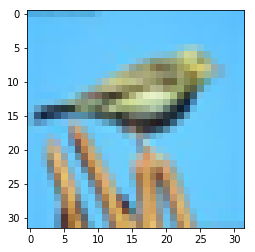

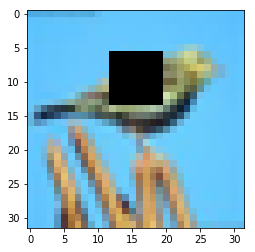

In [9]:
new_image= cutout(test_features[67])
plt.imshow(test_features[67])
plt.show()
plt.imshow(new_image)
plt.show()

#cv2_imshow(new_image)



## Network Architecture as per DAVID NET

In [10]:
# model definition

input_layer=Input(shape=(32,32,3))

#Prep
prep= Convolution2D(64, 3,3, input_shape=(32, 32, 3))(input_layer) 
prep = ZeroPadding2D((1,1))(prep)
prep = BatchNormalization()(prep)
prep = Activation('relu')(prep)

#layer 1
layer1=Convolution2D(128, 3,3)(prep)
layer1 = ZeroPadding2D((1,1))(layer1)
layer1 = BatchNormalization()(layer1)
layer1 = Activation('relu')(layer1)
layerp = MaxPooling2D(2)(layer1)

# Layer1_residual_block

#    Layer1_residual_block_identity_layer
layer1_residual_block_identity_layer = Lambda(lambda x:x, name='layer1_residual_block_identity_layer')(layerp)

#    Layer1_residual_block_res1
layer1_residual_block_res1_conv =  Convolution2D(filters=128, kernel_size=3, 
                                                 strides=1, bias=False, 
                                                 name='layer1_residual_block_res1_conv')(layer1_residual_block_identity_layer)
layer1_residual_block_res1_conv_padding = ZeroPadding2D((1,1), 
                                                        name='layer1_residual_block_res1_conv_padding')(layer1_residual_block_res1_conv)
layer1_residual_block_res1_bn = BatchNormalization(name='layer1_residual_block_res1_bn')(layer1_residual_block_res1_conv_padding)
layer1_residual_block_res1_relu = Activation('relu', name='layer1_residual_block_res1_relu')(layer1_residual_block_res1_bn)

#    Layer1_residual_block_res2
layer1_residual_block_res2_conv = Convolution2D(filters=128, kernel_size=3, 
                                                 strides=1, bias=False, 
                                                 name='layer1_residual_block_res2_conv')(layer1_residual_block_res1_relu)
layer1_residual_block_res2_conv_padding = ZeroPadding2D((1,1), 
                                                        name='layer1_residual_block_res2_conv_padding')(layer1_residual_block_res2_conv)
layer1_residual_block_res2_bn = BatchNormalization(name='layer1_residual_block_res2_bn')(layer1_residual_block_res2_conv_padding)
layer1_residual_block_res2_relu = Activation('relu', name='layer1_residual_block_res2_relu')(layer1_residual_block_res2_bn)

#    Layer1_residual_block_add
layer1_residual_block_add = Add(name='layer1_residual_block_add')([layer1_residual_block_res2_relu, 
                                                                  layer1_residual_block_identity_layer]
                                                                 )

#layer 2
layer2=Convolution2D(256, 3,3,border_mode='same')(layer1_residual_block_add) 
layer2 = ZeroPadding2D((1,1))(layer2)
layer2 = BatchNormalization()(layer2)
layer2 = Activation('relu')(layer2)

#layer 3
layer3=Convolution2D(512, 3,3,border_mode='same')(layer2) 
layer3 = BatchNormalization()(layer3)
layer3 = Activation('relu')(layer3)
layerq = MaxPooling2D(2)(layer3)

# Layer3_residual_block

#    Layer3_residual_block_identity_layer
layer3_residual_block_identity_layer = Lambda(lambda x:x, name='layer3_residual_block_identity_layer')(layerq)

#    Layer3_residual_block_res1
layer3_residual_block_res1_conv =  Convolution2D(filters=512, kernel_size=3, 
                                                 strides=1, bias=False, 
                                                 name='layer3_residual_block_res1_conv')(layer3_residual_block_identity_layer)
layer3_residual_block_res1_conv_padding = ZeroPadding2D((1,1), 
                                                        name='layer3_residual_block_res1_conv_padding')(layer3_residual_block_res1_conv)
layer3_residual_block_res1_bn = BatchNormalization(name='layer3_residual_block_res1_bn')(layer3_residual_block_res1_conv_padding)
layer3_residual_block_res1_relu = Activation('relu', name='layer3_residual_block_res1_relu')(layer3_residual_block_res1_bn)

#    Layer3_residual_block_res2
layer3_residual_block_res2_conv = Convolution2D(filters=512, kernel_size=3, 
                                                 strides=1, bias=False, 
                                                 name='layer3_residual_block_res2_conv')(layer3_residual_block_res1_relu)
layer3_residual_block_res2_conv_padding = ZeroPadding2D((1,1), 
                                                        name='layer3_residual_block_res2_conv_padding')(layer3_residual_block_res2_conv)
layer3_residual_block_res2_bn = BatchNormalization(name='layer3_residual_block_res2_bn')(layer3_residual_block_res2_conv_padding)
layer3_residual_block_res2_relu = Activation('relu', name='layer3_residual_block_res2_relu')(layer3_residual_block_res2_bn)

#    Layer1_residual_block_add
layer3_residual_block_add = Add(name='layer3_residual_block_add')([layer3_residual_block_res2_relu, 
                                                                  layer3_residual_block_identity_layer]
                                                                 )
# Classifier
# classifier
classifier_mp = MaxPooling2D(pool_size=4, name='classifier_mp')(layer3_residual_block_add)
classifier_flat = Flatten(name='classifier_flat')(classifier_mp)
classifier_fc = Dense(units=10, use_bias=False, name='classifier_fc')(classifier_flat)
classifier_logits = Activation('softmax', name='classifier_logits')(classifier_fc)
model = Model(input_layer, classifier_logits)




W0802 14:35:57.041103 140097708709760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0802 14:35:57.056174 140097708709760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3...)`
  """
W0802 14:35:57.060357 140097708709760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0802 14:35:57.086069 140097708709760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packag

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 30, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 32, 32, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
activation

In [0]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

## One Cycle LR Implementation

In [0]:
# Implement One Cycle Policy Algorithm in the Keras Callback Class

from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras import backend as K
from keras.callbacks import *

class CyclicLR(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())

In [14]:
# Define Ony Cycle Policy parameters and train model
########################################################################################
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# CLR parameters

batch_size = 512
epochs = 24
max_lr = 0.025
base_lr = 0.00000001
max_m = 0.98
base_m = 0.85

cyclical_momentum = True
augment = False
cycles = 2.35

iterations = round(len(X_train)/batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)


model.compile(loss='categorical_crossentropy', optimizer=SGD(0.00000001), metrics=['accuracy'])

clr =  CyclicLR(base_lr=base_lr,
                max_lr=max_lr,
                step_size=step_size,
                max_m=max_m,
                base_m=base_m,
                cyclical_momentum=cyclical_momentum)
    
callbacks = [clr,
            ModelCheckpoint(filepath='best_model.h5', monitor='val_acc',mode='max',verbose=1,save_best_only=True)]


from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False, preprocessing_function=cutout)
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(X_train, train_labels, batch_size = 512), samples_per_epoch = train_features.shape[0], nb_epoch = epochs, validation_data = (X_test, test_labels), verbose=1, callbacks=callbacks)
end = time.time()

W0802 14:35:58.947429 140097708709760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<__main__..., steps_per_epoch=97, epochs=24)`
W0802 14:35:59.057326 140097708709760 

Epoch 1/24
97/97 [==============================] - 64s 662ms/step - loss: 2.5381 - acc: 0.3381 - val_loss: 4.6693 - val_acc: 0.3392

Epoch 00001: val_acc improved from -inf to 0.33920, saving model to best_model.h5
Epoch 2/24
97/97 [==============================] - 56s 578ms/step - loss: 1.6135 - acc: 0.5014 - val_loss: 1.9686 - val_acc: 0.5043

Epoch 00002: val_acc improved from 0.33920 to 0.50430, saving model to best_model.h5
Epoch 3/24
97/97 [==============================] - 51s 530ms/step - loss: 1.3296 - acc: 0.5927 - val_loss: 2.3271 - val_acc: 0.5301

Epoch 00003: val_acc improved from 0.50430 to 0.53010, saving model to best_model.h5
Epoch 4/24
97/97 [==============================] - 51s 526ms/step - loss: 1.1544 - acc: 0.6447 - val_loss: 1.4339 - val_acc: 0.6164

Epoch 00004: val_acc improved from 0.53010 to 0.61640, saving model to best_model.h5
Epoch 5/24
97/97 [==============================] - 51s 530ms/step - loss: 0.9038 - acc: 0.7102 - val_loss: 1.0355 - val_acc: 0

In [15]:
print ("Model took %0.2f seconds to train"%(end - start))


Model took 1252.28 seconds to train


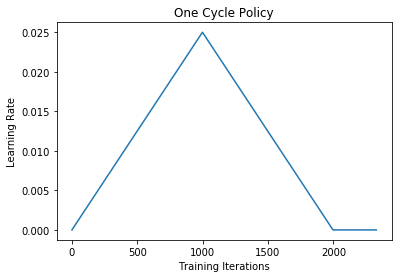

In [16]:
# Plot Learning Rate
import matplotlib.pyplot as plt
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("One Cycle Policy")
plt.show()

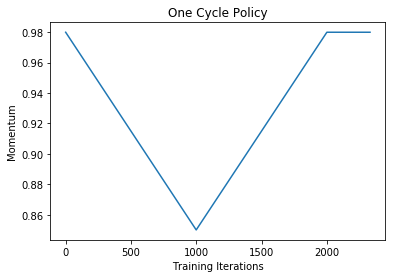

In [17]:
# Plot momentum
import matplotlib.pyplot as plt
plt.plot(clr.history['iterations'], clr.history['momentum'])
plt.xlabel('Training Iterations')
plt.ylabel('Momentum')
plt.title("One Cycle Policy")
plt.show()